# rule based feature 추출

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from extract_rule_based_features import ExtractFeatures, detect_bead
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
from collections import Counter

%matplotlib inline

## Anode

In [2]:
Anode_Normal = sorted([x for x in Path("../data/230507/Anode/Normal").glob("*.csv")])
Anode_Normal

[PosixPath('../data/230507/Anode/Normal/1.csv'),
 PosixPath('../data/230507/Anode/Normal/10.csv'),
 PosixPath('../data/230507/Anode/Normal/11.csv'),
 PosixPath('../data/230507/Anode/Normal/12.csv'),
 PosixPath('../data/230507/Anode/Normal/14.csv'),
 PosixPath('../data/230507/Anode/Normal/15.csv'),
 PosixPath('../data/230507/Anode/Normal/16.csv'),
 PosixPath('../data/230507/Anode/Normal/17.csv'),
 PosixPath('../data/230507/Anode/Normal/18.csv'),
 PosixPath('../data/230507/Anode/Normal/19.csv'),
 PosixPath('../data/230507/Anode/Normal/2.csv'),
 PosixPath('../data/230507/Anode/Normal/20.csv'),
 PosixPath('../data/230507/Anode/Normal/20230412_110032_0__03_Total.csv'),
 PosixPath('../data/230507/Anode/Normal/21.csv'),
 PosixPath('../data/230507/Anode/Normal/22.csv'),
 PosixPath('../data/230507/Anode/Normal/23.csv'),
 PosixPath('../data/230507/Anode/Normal/24.csv'),
 PosixPath('../data/230507/Anode/Normal/25.csv'),
 PosixPath('../data/230507/Anode/Normal/26.csv'),
 PosixPath('../data/230507/

In [3]:
Anode_Abnormal = sorted([x for x in Path("../data/230507/Anode/Abnormal").glob("*.csv")])
Anode_Abnormal

[PosixPath('../data/230507/Anode/Abnormal/20230412_105553_0__01_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_105804_0__02_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110249_0__04_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110451_0__05_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110735_0__06_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110928_0__07_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_111152_0__08_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_111719_0__09_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_111935_0__10_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112153_0__11_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112415_0__12_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112642_0__13_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112855_0__14_Total.csv'),

In [4]:
len(Anode_Abnormal)

18

In [5]:
def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

In [6]:
def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

### Dataset별 bead detection 후 time series concat

In [11]:
def slice_bead_data(path):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
    else:
        data['label'] = 0
        
    bead_array = detect_bead(data['LO'])
    
    total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
    
    for i in range(1, len(bead_array)):
        bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
        total_data = pd.concat([total_data, bead_data])
    
    return total_data

## Train Test split
### Train -> 35개 정상 dataset 중 80%인 28개
### Test -> 18개 비정상 dataset + 정상 7개 dataset = 25개 dataset

In [17]:
data_folder_list = Anode_Normal + Anode_Abnormal
num_train_dataset = 28
Anode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label'])
Anode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label'])
for i in range(num_train_dataset):
    bead_i = slice_bead_data(str(data_folder_list[i]))
    Anode_Train = pd.concat([Anode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_bead_data(str(data_folder_list[i]))
    Anode_Test = pd.concat([Anode_Test, bead_i])


warning index: 40140
error index: 40239
warning index: 40690
error index: 40789
warning index: 41239
error index: 41338
warning index: 41788
error index: 41887
warning index: 42337
error index: 42436
warning index: 42886
error index: 42985
warning index: 43436
error index: 43535
warning index: 43986
error index: 44085
warning index: 44535
error index: 44634
warning index: 45085
error index: 45184
warning index: 45634
error index: 45733
warning index: 46184
error index: 46283
warning index: 46733
error index: 46832
warning index: 47282
error index: 47381
warning index: 47832
error index: 47931
warning index: 48381
error index: 48480
warning index: 48930
error index: 49029
warning index: 49479
error index: 49578
warning index: 50028
error index: 50127
warning index: 50577
error index: 50676
warning index: 51127
error index: 51226
warning index: 51676
error index: 51775
warning index: 52226
error index: 52325
warning index: 52775
error index: 52874
warning index: 53325
error index: 53424


In [30]:
Anode_Train = Anode_Train.astype(float)
Anode_Test = Anode_Test.astype(float)

In [31]:
Anode_Train_y = Anode_Train['label']
Anode_Train_X = Anode_Train.drop('label', axis=1)
Anode_Test_y = Anode_Test['label']
Anode_Test_X = Anode_Test.drop('label', axis=1)

In [32]:
Anode_Train_y

40138    0.0
40139    0.0
40140    0.0
40141    0.0
40142    0.0
40143    0.0
40144    0.0
40145    0.0
40146    0.0
40147    0.0
40148    0.0
40149    0.0
40150    0.0
40151    0.0
40152    0.0
40153    0.0
40154    0.0
40155    0.0
40156    0.0
40157    0.0
40158    0.0
40159    0.0
40160    0.0
40161    0.0
40162    0.0
40163    0.0
40164    0.0
40165    0.0
40166    0.0
40167    0.0
        ... 
70752    0.0
70753    0.0
70754    0.0
70755    0.0
70756    0.0
70757    0.0
70758    0.0
70759    0.0
70760    0.0
70761    0.0
70762    0.0
70763    0.0
70764    0.0
70765    0.0
70766    0.0
70767    0.0
70768    0.0
70769    0.0
70770    0.0
70771    0.0
70772    0.0
70773    0.0
70774    0.0
70775    0.0
70776    0.0
70777    0.0
70778    0.0
70779    0.0
70780    0.0
70781    0.0
Name: label, Length: 150928, dtype: float64

### Isolation Forest

In [34]:
IF_clf=IsolationForest(random_state=72).fit(Anode_Train_X)
IF_pred = IF_clf.predict(Anode_Test_X)
IF_pred = np.where(IF_pred==1, 0, 1)

In [35]:
tn, fp, fn, tp = confusion_matrix(Anode_Test_y, IF_pred).ravel()
(tn, fp, fn, tp)

(33751, 3948, 57756, 40392)

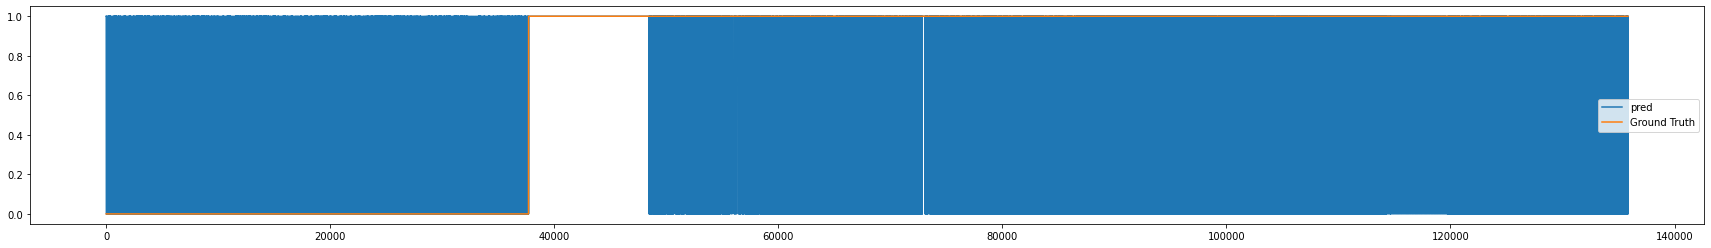

In [37]:
fig = plt.figure(figsize=(30, 4))
plt.plot(IF_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

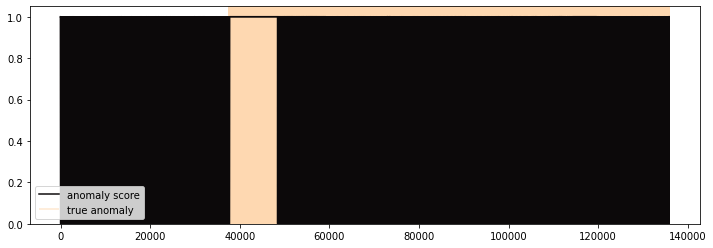

In [38]:
check_graph(IF_pred, np.array(Anode_Test_y))
plt.show()

In [39]:
IF_anomaly_score = IF_clf.score_samples(Anode_Test_X)

In [40]:
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-IF_anomaly_score, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-IF_anomaly_score), 
                                                                  end=max(-IF_anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.7459, F1: 0.8408, Precision: 0.7429, Recall: 0.9685


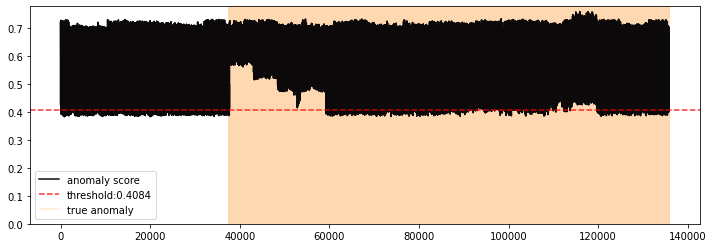

In [41]:
check_graph(-IF_anomaly_score, np.array(Anode_Test_y), threshold=threshold)
plt.show()

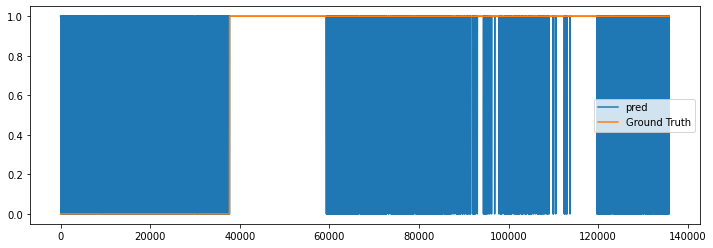

In [42]:
IF_pred = -IF_anomaly_score >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(IF_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [22]:
bead_counter = []
for i in range(len(IF_pred)//54):
    bead_counter.append(dict(Counter(IF_pred[i*54: (i+1)*54])))
print(bead_counter)

[{True: 12, False: 42}, {False: 50, True: 4}, {True: 11, False: 43}, {True: 15, False: 39}, {False: 46, True: 8}, {False: 48, True: 6}, {False: 44, True: 10}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 50, False: 4}, {True: 48, False: 6}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {False: 11, True: 43}, {True: 33, False: 21}, {True: 53, False: 1}]


### One-class SVM

In [23]:
OCS_clf = OneClassSVM().fit(Anode_Train_X)
OCS_pred = OCS_clf.predict(Anode_Test_X)
OCS_pred = np.where(OCS_pred==1, 0, 1)

In [24]:
tn, fp, fn, tp = confusion_matrix(Anode_Test_y, OCS_pred).ravel()
(tn, fp, fn, tp)

(201, 177, 64, 908)

In [26]:
OCS_anomaly_score = OCS_clf.score_samples(Anode_Test_X)

In [27]:
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-OCS_anomaly_score, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-OCS_anomaly_score), 
                                                                  end=max(-OCS_anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.9252, F1: 0.9043, Precision: 0.9361, Recall: 0.8745


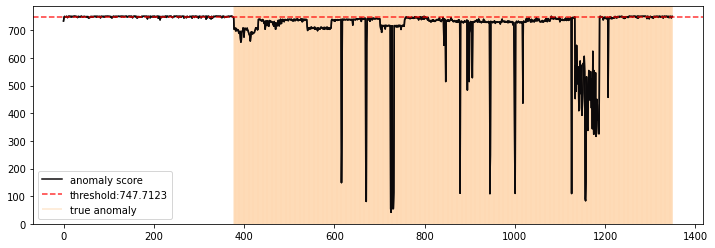

In [28]:
check_graph(OCS_anomaly_score, np.array(Anode_Test_y), threshold=-threshold)
plt.show()

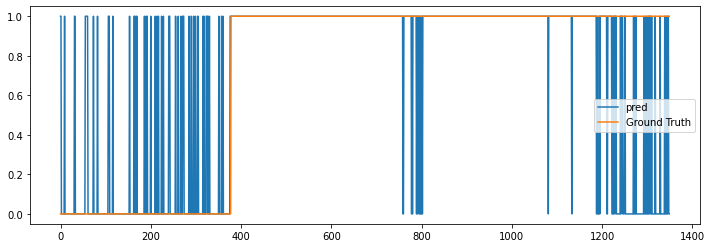

In [29]:
OCS_pred = OCS_anomaly_score <= -threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(OCS_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [30]:
bead_counter = []
for i in range(len(OCS_pred)//54):
    bead_counter.append(dict(Counter(OCS_pred[i*54: (i+1)*54])))
print(bead_counter)

[{True: 5, False: 49}, {False: 44, True: 10}, {True: 3, False: 51}, {False: 44, True: 10}, {False: 45, True: 9}, {False: 42, True: 12}, {True: 9, False: 45}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 43, False: 11}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 52, False: 2}, {True: 54}, {False: 22, True: 32}, {False: 45, True: 9}, {False: 42, True: 12}]


### MoG

In [31]:
# Define the number of mixture components (Gaussian distributions)
n_components = 2

# Create a Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components, random_state=72).fit(Anode_Train_X)

In [32]:
# Predict cluster labels for each data point
cluster_labels = gmm.predict(Anode_Test_X)

# Predict probabilities of each data point belonging to each cluster
cluster_probs = gmm.predict_proba(Anode_Test_X)

AUROC: 0.9977, F1: 0.1053, Precision: 1.0000, Recall: 0.0556


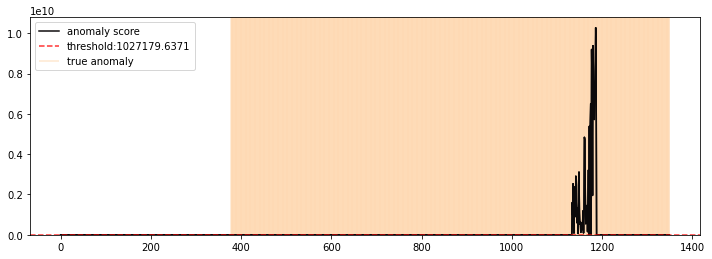

In [34]:
MoG_anomaly_score = gmm.score_samples(Anode_Test_X)

(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-MoG_anomaly_score, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-MoG_anomaly_score), 
                                                                  end=max(-MoG_anomaly_score), 
                                                                  step_num=10000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
check_graph(-MoG_anomaly_score, np.array(Anode_Test_y), threshold=threshold)
plt.show()

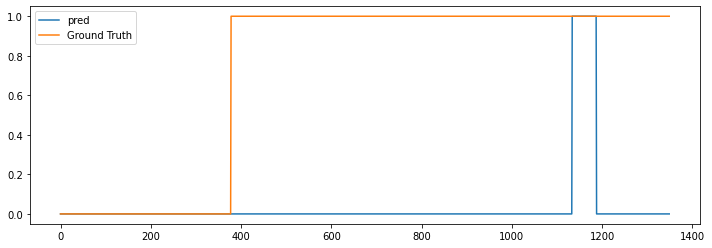

In [35]:
MoG_pred = -MoG_anomaly_score >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(MoG_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [37]:
bead_counter = []
for i in range(len(MoG_pred)//54):
    bead_counter.append(dict(Counter(MoG_pred[i*54: (i+1)*54])))
print(bead_counter)

[{False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {True: 54}, {False: 54}, {False: 54}, {False: 54}]


### Parzen windows

In [39]:
bandwidth = 1.0
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(Anode_Train_X)

AUROC: 0.9499, F1: 0.8377, Precision: 0.9972, Recall: 0.7222


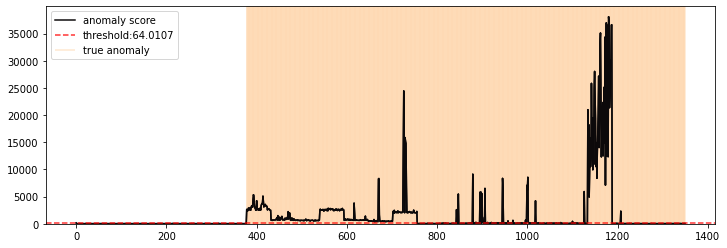

In [40]:
# Estimate the density at each value in the range
# density = np.exp(kde.score_samples(Anode_Test_X))
density = kde.score_samples(Anode_Test_X)
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-density, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-density), 
                                                                  end=max(-density), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
check_graph(-density, np.array(Anode_Test_y), threshold=threshold)
plt.show()

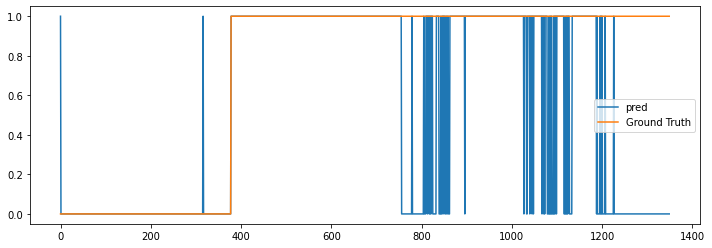

In [41]:
PW_pred = -density >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(PW_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [42]:
bead_counter = []
for i in range(len(PW_pred)//54):
    bead_counter.append(dict(Counter(PW_pred[i*54: (i+1)*54])))
print(bead_counter)

[{True: 1, False: 53}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 53, True: 1}, {False: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {False: 52, True: 2}, {True: 28, False: 26}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 44, False: 10}, {False: 25, True: 29}, {True: 54}, {False: 48, True: 6}, {False: 54}, {False: 54}]


In [43]:
len(bead_counter)

25

---